In [ ]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tqdm import tqdm

Making Data Set


In [ ]:
adj_mx_la = pd.read_pickle("/content/drive/MyDrive/Traffic Prediction/Dataset/LA/adj_mx.pkl")

In [ ]:
sensor_list_la = adj_mx_la[0]

In [ ]:
import argparse
import numpy as np
import os
import pandas as pd

def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y


def generate_train_val_test(inputFile,outPutDir):
    df = pd.read_hdf(inputFile)
    # 0 is the latest observed sample.
    x_offsets = np.sort(
        # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
        np.concatenate((np.arange(-11, 1, 1),))
    )
    # Predict the next one hour
    y_offsets = np.sort(np.arange(1, 13, 1))
    # x: (num_samples, input_length, num_nodes, input_dim)
    # y: (num_samples, output_length, num_nodes, output_dim)
    x, y = generate_graph_seq2seq_io_data(
        df,
        x_offsets=x_offsets,
        y_offsets=y_offsets,
        add_time_in_day=True,
        add_day_in_week=False,
    )

    print("x shape: ", x.shape, ", y shape: ", y.shape)
    # Write the data into npz file.
    # num_test = 6831, using the last 6831 examples as testing.
    # for the rest: 7/8 is used for training, and 1/8 is used for validation.
    num_samples = x.shape[0]
    num_test = round(num_samples * 0.2)
    num_train = round(num_samples * 0.7)
    num_val = num_samples - num_test - num_train

    # train
    x_train, y_train = x[:num_train], y[:num_train]
    # val
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # test
    x_test, y_test = x[-num_test:], y[-num_test:]

    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        print(cat, "x: ", _x.shape, "y:", _y.shape)
        np.savez_compressed(
            os.path.join(outPutDir, "%s.npz" % cat),
            x=_x,
            y=_y,
            x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
        )


In [ ]:
inputFile = '/content/drive/MyDrive/Traffic Prediction/Dataset/metr-la.h5'
outPutDir = '/content/drive/MyDrive/Traffic Prediction/Dataset/LA'

generate_train_val_test(inputFile,outPutDir)

x shape:  (34249, 12, 207, 2) , y shape:  (34249, 12, 207, 2)
train x:  (23974, 12, 207, 2) y: (23974, 12, 207, 2)
val x:  (3425, 12, 207, 2) y: (3425, 12, 207, 2)
test x:  (6850, 12, 207, 2) y: (6850, 12, 207, 2)


In [ ]:
train_LA = np.load("/content/drive/MyDrive/Traffic Prediction/Dataset/LA/train.npz")
test_LA = np.load("/content/drive/MyDrive/Traffic Prediction/Dataset/LA/test.npz")
val_LA = np.load("/content/drive/MyDrive/Traffic Prediction/Dataset/LA/val.npz")

How Does our Data Set Look Like?

In [ ]:
print(train_LA["x"].shape, train_LA["y"].shape, train_LA["x_offsets"].shape, train_LA["y_offsets"].shape)
print(test_LA["x"].shape, test_LA["y"].shape, test_LA["x_offsets"].shape, test_LA["y_offsets"].shape)
print(val_LA["x"].shape, val_LA["y"].shape, val_LA["x_offsets"].shape, val_LA["y_offsets"].shape)

(23974, 12, 207, 2) (23974, 12, 207, 2) (12, 1) (12, 1)
(6850, 12, 207, 2) (6850, 12, 207, 2) (12, 1) (12, 1)
(3425, 12, 207, 2) (3425, 12, 207, 2) (12, 1) (12, 1)


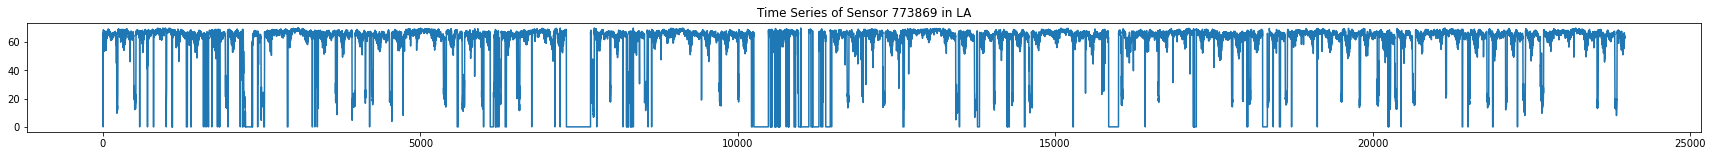

In [ ]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 0, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][0] + " in LA")
plt.show()

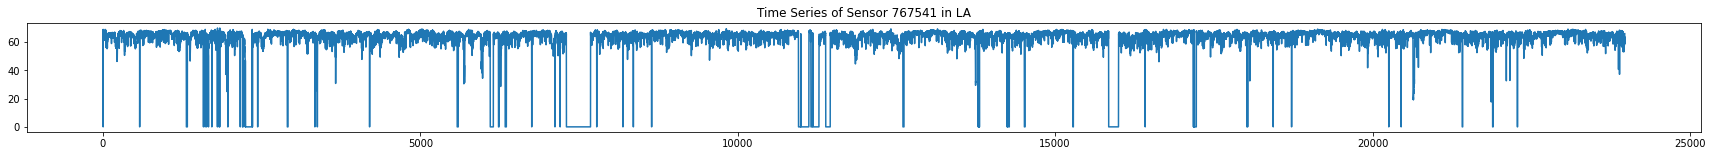

In [ ]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 1, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][1] + " in LA")
plt.show()

In [ ]:
AvgErrorHyperParam = list()
for c in range(5,20,5):
    MaeData = list()
    RmseData = list()
    sampleSize=15
    for i in tqdm(range(sampleSize)):
        print("Sensor: ", sensor_list_la[i], end=", ")
        train_X = train_LA["x"][:, :, i, 0]
        train_y = train_LA["y"][:, :, i, 0]
        val_X = val_LA["x"][:, :, i, 0]
        val_y = val_LA["y"][:, :, i, 0]
        regr = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=c, max_iter=c*3000)))
        regr = regr.fit(train_X, train_y)
        prediction = regr.predict(val_X)
        mae, rmse, mape = [], [], []
        for pred, gt in zip(prediction, val_y):
            mae.append(mean_absolute_error(pred, gt))
            rmse.append(np.sqrt(mean_squared_error(pred, gt)))
        MaeData.append(round(sum(mae) / len(mae), 3))
        RmseData.append(round(sum(rmse) / len(rmse), 3))
        print("AVG MAE: ", round(sum(mae) / len(mae), 3), end=", ")
        print("AVG RMSE: ", round(sum(rmse) / len(rmse), 3), end=", ")
    error = list()
    error.append(c)
    avgMAEperSesor = round(sum(MaeData) / len(MaeData), 4)
    avgRMSEperSesor = round(sum(RmseData) / len(RmseData), 4)
    error.append(avgMAEperSesor)
    error.append(avgRMSEperSesor)
    AvgErrorHyperParam.append(error)

import pickle

with open('/content/drive/MyDrive/Traffic Prediction/Results/AvgErrorHyperParam.pkl', 'wb') as f:
  pickle.dump(np.array(AvgErrorHyperParam), f)

AvgErrorHyperParam = np.array(AvgErrorHyperParam)

index = np.argmin(AvgErrorHyperParam[:,1])
print("Hyper param C selected will be : {}".format(AvgErrorHyperParam[index][0]))

SelectedC = AvgErrorHyperParam[index][0]


    

  0%|          | 0/15 [00:00<?, ?it/s]

Sensor:  773869, 

  7%|▋         | 1/15 [00:29<06:55, 29.64s/it]

AVG MAE:  3.667, AVG RMSE:  4.582, Sensor:  767541, 

 13%|█▎        | 2/15 [01:01<06:40, 30.80s/it]

AVG MAE:  2.814, AVG RMSE:  3.701, Sensor:  767542, 

 20%|██        | 3/15 [01:40<06:56, 34.70s/it]

AVG MAE:  3.548, AVG RMSE:  4.574, Sensor:  717447, 

 27%|██▋       | 4/15 [02:05<05:37, 30.68s/it]

AVG MAE:  4.974, AVG RMSE:  6.149, Sensor:  717446, 

 33%|███▎      | 5/15 [02:23<04:23, 26.35s/it]

AVG MAE:  6.718, AVG RMSE:  8.2, Sensor:  717445, 

 40%|████      | 6/15 [02:45<03:42, 24.69s/it]

AVG MAE:  6.099, AVG RMSE:  7.479, Sensor:  773062, 

 47%|████▋     | 7/15 [03:13<03:26, 25.77s/it]

AVG MAE:  4.839, AVG RMSE:  6.074, Sensor:  767620, 

 53%|█████▎    | 8/15 [03:38<02:58, 25.46s/it]

AVG MAE:  2.99, AVG RMSE:  3.9, Sensor:  737529, 

 60%|██████    | 9/15 [04:03<02:32, 25.34s/it]

AVG MAE:  5.001, AVG RMSE:  6.241, Sensor:  717816, 

 67%|██████▋   | 10/15 [04:29<02:08, 25.66s/it]

AVG MAE:  5.06, AVG RMSE:  6.376, Sensor:  765604, 

 73%|███████▎  | 11/15 [04:53<01:41, 25.28s/it]

AVG MAE:  4.678, AVG RMSE:  5.82, Sensor:  767471, 

 80%|████████  | 12/15 [05:17<01:14, 24.77s/it]

AVG MAE:  4.224, AVG RMSE:  5.416, Sensor:  716339, 

 87%|████████▋ | 13/15 [05:34<00:44, 22.46s/it]

AVG MAE:  6.573, AVG RMSE:  8.173, Sensor:  773906, 

 93%|█████████▎| 14/15 [06:01<00:23, 23.81s/it]

AVG MAE:  5.329, AVG RMSE:  6.745, Sensor:  765273, 

100%|██████████| 15/15 [06:25<00:00, 25.71s/it]


AVG MAE:  5.636, AVG RMSE:  6.965, 

  0%|          | 0/15 [00:00<?, ?it/s]

Sensor:  773869, 

  7%|▋         | 1/15 [00:44<10:23, 44.53s/it]

AVG MAE:  3.664, AVG RMSE:  4.574, Sensor:  767541, 

 13%|█▎        | 2/15 [01:29<09:38, 44.52s/it]

AVG MAE:  2.814, AVG RMSE:  3.702, Sensor:  767542, 

 20%|██        | 3/15 [02:27<10:12, 51.04s/it]

AVG MAE:  3.548, AVG RMSE:  4.574, Sensor:  717447, 

 27%|██▋       | 4/15 [03:01<08:05, 44.15s/it]

AVG MAE:  4.975, AVG RMSE:  6.148, Sensor:  717446, 

 33%|███▎      | 5/15 [03:25<06:08, 36.90s/it]

AVG MAE:  6.718, AVG RMSE:  8.199, Sensor:  717445, 

 40%|████      | 6/15 [03:55<05:09, 34.40s/it]

AVG MAE:  6.1, AVG RMSE:  7.479, Sensor:  773062, 

 47%|████▋     | 7/15 [04:38<04:59, 37.50s/it]

AVG MAE:  4.839, AVG RMSE:  6.076, Sensor:  767620, 

 53%|█████▎    | 8/15 [05:14<04:18, 36.91s/it]

AVG MAE:  2.99, AVG RMSE:  3.901, Sensor:  737529, 

 60%|██████    | 9/15 [05:49<03:38, 36.43s/it]

AVG MAE:  4.999, AVG RMSE:  6.238, Sensor:  717816, 

 67%|██████▋   | 10/15 [06:26<03:02, 36.48s/it]

AVG MAE:  5.058, AVG RMSE:  6.374, Sensor:  765604, 

 73%|███████▎  | 11/15 [06:59<02:22, 35.50s/it]

AVG MAE:  4.679, AVG RMSE:  5.821, Sensor:  767471, 

 80%|████████  | 12/15 [07:30<01:42, 34.14s/it]

AVG MAE:  4.223, AVG RMSE:  5.415, Sensor:  716339, 

 87%|████████▋ | 13/15 [07:51<01:00, 30.17s/it]

AVG MAE:  6.574, AVG RMSE:  8.175, Sensor:  773906, 

 93%|█████████▎| 14/15 [08:29<00:32, 32.44s/it]

AVG MAE:  5.328, AVG RMSE:  6.744, Sensor:  765273, 

100%|██████████| 15/15 [09:02<00:00, 36.18s/it]


AVG MAE:  5.637, AVG RMSE:  6.967, 

  0%|          | 0/15 [00:00<?, ?it/s]

Sensor:  773869, 

  7%|▋         | 1/15 [00:51<12:04, 51.75s/it]

AVG MAE:  3.663, AVG RMSE:  4.572, Sensor:  767541, 

 13%|█▎        | 2/15 [01:53<12:26, 57.46s/it]

AVG MAE:  2.814, AVG RMSE:  3.702, Sensor:  767542, 

 20%|██        | 3/15 [03:18<14:00, 70.07s/it]

AVG MAE:  3.548, AVG RMSE:  4.574, Sensor:  717447, 

 27%|██▋       | 4/15 [04:05<11:10, 60.99s/it]

AVG MAE:  4.974, AVG RMSE:  6.149, Sensor:  717446, 

 33%|███▎      | 5/15 [04:36<08:21, 50.19s/it]

AVG MAE:  6.719, AVG RMSE:  8.201, Sensor:  717445, 

 40%|████      | 6/15 [05:18<07:08, 47.60s/it]

AVG MAE:  6.1, AVG RMSE:  7.48, Sensor:  773062, 

 47%|████▋     | 7/15 [06:19<06:54, 51.84s/it]

AVG MAE:  4.838, AVG RMSE:  6.073, Sensor:  767620, 

 53%|█████▎    | 8/15 [07:08<05:57, 51.02s/it]

AVG MAE:  2.99, AVG RMSE:  3.9, Sensor:  737529, 

 60%|██████    | 9/15 [07:59<05:05, 50.92s/it]

AVG MAE:  4.999, AVG RMSE:  6.237, Sensor:  717816, 

 67%|██████▋   | 10/15 [08:54<04:20, 52.08s/it]

AVG MAE:  5.059, AVG RMSE:  6.375, Sensor:  765604, 

 73%|███████▎  | 11/15 [09:42<03:24, 51.05s/it]

AVG MAE:  4.679, AVG RMSE:  5.82, Sensor:  767471, 

 80%|████████  | 12/15 [10:28<02:28, 49.42s/it]

AVG MAE:  4.224, AVG RMSE:  5.416, Sensor:  716339, 

 87%|████████▋ | 13/15 [10:56<01:25, 42.96s/it]

AVG MAE:  6.573, AVG RMSE:  8.174, Sensor:  773906, 

 93%|█████████▎| 14/15 [11:54<00:47, 47.33s/it]

AVG MAE:  5.328, AVG RMSE:  6.744, Sensor:  765273, 

100%|██████████| 15/15 [12:43<00:00, 50.87s/it]

AVG MAE:  5.636, AVG RMSE:  6.966, Hyper param C selected will be : 15.0


In [ ]:
AvgErrorHyperParam = pd.read_pickle("/content/drive/MyDrive/Traffic Prediction/Results/AvgErrorHyperParam.pkl")
AvgErrorHyperParam = np.array(AvgErrorHyperParam)

index = np.argmin(AvgErrorHyperParam[:,1])
print("Hyper param C selected will be : {}".format(AvgErrorHyperParam[index][0]))

SelectedC = AvgErrorHyperParam[index][0]

Hyper param C selected will be : 15.0


In [ ]:

#Running on Testing Split with selected Hyper Param

MaeData = list()
RmseData = list()
for i in tqdm(range(len(sensor_list_la))):
    print("Sensor: ", sensor_list_la[i], end=", ")
    train_X = train_LA["x"][:, :, i, 0]
    train_y = train_LA["y"][:, :, i, 0]
    test_X = test_LA["x"][:, :, i, 0]
    test_y = test_LA["y"][:, :, i, 0]
    regr = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=SelectedC, max_iter=SelectedC*5000)))
    regr = regr.fit(train_X, train_y)
    prediction = regr.predict(test_X)
    mae, rmse, mape = [], [], []
    for pred, gt in zip(prediction, test_y):
        mae.append(mean_absolute_error(pred, gt))
        rmse.append(np.sqrt(mean_squared_error(pred, gt)))
    MaeData.append(round(sum(mae) / len(mae), 3))
    RmseData.append(round(sum(rmse) / len(rmse), 3))
    print("AVG MAE: ", round(sum(mae) / len(mae), 3), end=", ")
    print("AVG RMSE: ", round(sum(rmse) / len(rmse), 3), end=", ")

import pickle

with open('/content/drive/MyDrive/Traffic Prediction/Results/SVRErrorData.pkl', 'wb') as f:
  pickle.dump([MaeData, RmseData], f)


  0%|          | 0/207 [00:00<?, ?it/s]

Sensor:  773869, 

  0%|          | 1/207 [00:58<3:19:40, 58.16s/it]

AVG MAE:  5.183, AVG RMSE:  6.537, Sensor:  767541, 

  1%|          | 2/207 [02:09<3:44:16, 65.64s/it]

AVG MAE:  3.541, AVG RMSE:  4.606, Sensor:  767542, 

  1%|▏         | 3/207 [03:41<4:24:12, 77.71s/it]

AVG MAE:  4.547, AVG RMSE:  5.821, Sensor:  717447, 

  2%|▏         | 4/207 [04:32<3:47:12, 67.16s/it]

AVG MAE:  4.986, AVG RMSE:  6.167, Sensor:  717446, 

  2%|▏         | 5/207 [05:06<3:06:51, 55.50s/it]

AVG MAE:  6.376, AVG RMSE:  7.68, Sensor:  717445, 

  3%|▎         | 6/207 [05:49<2:50:51, 51.00s/it]

AVG MAE:  6.019, AVG RMSE:  7.41, Sensor:  773062, 

  3%|▎         | 7/207 [06:45<2:56:18, 52.89s/it]

AVG MAE:  5.121, AVG RMSE:  6.381, Sensor:  767620, 

  4%|▍         | 8/207 [07:35<2:52:16, 51.94s/it]

AVG MAE:  3.527, AVG RMSE:  4.562, Sensor:  737529, 

  4%|▍         | 9/207 [08:30<2:54:23, 52.84s/it]

AVG MAE:  5.373, AVG RMSE:  6.695, Sensor:  717816, 

  5%|▍         | 10/207 [09:27<2:57:09, 53.96s/it]

AVG MAE:  5.863, AVG RMSE:  7.351, Sensor:  765604, 

  5%|▌         | 11/207 [10:17<2:52:41, 52.87s/it]

AVG MAE:  3.984, AVG RMSE:  5.083, Sensor:  767471, 

  6%|▌         | 12/207 [11:06<2:47:44, 51.61s/it]

AVG MAE:  4.798, AVG RMSE:  6.273, Sensor:  716339, 

  6%|▋         | 13/207 [11:36<2:26:01, 45.16s/it]

AVG MAE:  6.086, AVG RMSE:  7.489, Sensor:  773906, 

  7%|▋         | 14/207 [12:37<2:40:32, 49.91s/it]

AVG MAE:  5.253, AVG RMSE:  6.767, Sensor:  765273, 

  7%|▋         | 15/207 [13:31<2:43:28, 51.08s/it]

AVG MAE:  6.444, AVG RMSE:  7.932, Sensor:  716331, 

  8%|▊         | 16/207 [14:10<2:30:53, 47.40s/it]

AVG MAE:  6.271, AVG RMSE:  7.55, Sensor:  771667, 

  8%|▊         | 17/207 [15:21<2:53:06, 54.67s/it]

AVG MAE:  2.577, AVG RMSE:  3.217, Sensor:  716337, 

  9%|▊         | 18/207 [16:09<2:45:35, 52.57s/it]

AVG MAE:  5.383, AVG RMSE:  6.744, Sensor:  769953, 

  9%|▉         | 19/207 [16:53<2:36:22, 49.91s/it]

AVG MAE:  4.054, AVG RMSE:  5.05, Sensor:  769402, 

 10%|▉         | 20/207 [17:47<2:40:06, 51.37s/it]

AVG MAE:  4.614, AVG RMSE:  5.761, Sensor:  769403, 

 10%|█         | 21/207 [18:49<2:48:38, 54.40s/it]

AVG MAE:  5.174, AVG RMSE:  6.487, Sensor:  769819, 

 11%|█         | 22/207 [19:39<2:44:01, 53.20s/it]

AVG MAE:  4.072, AVG RMSE:  5.113, Sensor:  769405, 

 11%|█         | 23/207 [20:13<2:25:31, 47.45s/it]

AVG MAE:  4.534, AVG RMSE:  5.557, Sensor:  716941, 

 12%|█▏        | 24/207 [20:56<2:20:37, 46.11s/it]

AVG MAE:  7.297, AVG RMSE:  9.06, Sensor:  717578, 

 12%|█▏        | 25/207 [21:48<2:24:41, 47.70s/it]

AVG MAE:  4.592, AVG RMSE:  5.835, Sensor:  716960, 

 13%|█▎        | 26/207 [22:23<2:12:59, 44.08s/it]

AVG MAE:  7.663, AVG RMSE:  9.29, Sensor:  717804, 

 13%|█▎        | 27/207 [22:53<1:59:27, 39.82s/it]

AVG MAE:  6.152, AVG RMSE:  7.575, Sensor:  767572, 

 14%|█▎        | 28/207 [23:53<2:16:16, 45.68s/it]

AVG MAE:  3.471, AVG RMSE:  4.517, Sensor:  767573, 

 14%|█▍        | 29/207 [25:14<2:47:08, 56.34s/it]

AVG MAE:  4.231, AVG RMSE:  5.519, Sensor:  773012, 

 14%|█▍        | 30/207 [26:32<3:05:45, 62.97s/it]

AVG MAE:  4.055, AVG RMSE:  5.099, Sensor:  773013, 

 15%|█▍        | 31/207 [27:01<2:34:44, 52.76s/it]

AVG MAE:  6.752, AVG RMSE:  8.575, Sensor:  764424, 

 15%|█▌        | 32/207 [28:00<2:38:54, 54.48s/it]

AVG MAE:  5.216, AVG RMSE:  6.703, Sensor:  769388, 

 16%|█▌        | 33/207 [28:43<2:28:42, 51.28s/it]

AVG MAE:  6.073, AVG RMSE:  7.698, Sensor:  716328, 

 16%|█▋        | 34/207 [29:35<2:27:44, 51.24s/it]

AVG MAE:  5.061, AVG RMSE:  6.231, Sensor:  717819, 

 17%|█▋        | 35/207 [30:37<2:36:53, 54.73s/it]

AVG MAE:  4.824, AVG RMSE:  6.144, Sensor:  769941, 

 17%|█▋        | 36/207 [31:25<2:30:10, 52.69s/it]

AVG MAE:  4.142, AVG RMSE:  5.196, Sensor:  760987, 

 18%|█▊        | 37/207 [32:07<2:19:57, 49.40s/it]

AVG MAE:  5.677, AVG RMSE:  7.302, Sensor:  718204, 

 18%|█▊        | 38/207 [32:51<2:14:52, 47.88s/it]

AVG MAE:  4.928, AVG RMSE:  6.122, Sensor:  718045, 

 19%|█▉        | 39/207 [33:21<1:59:00, 42.50s/it]

AVG MAE:  8.711, AVG RMSE:  10.74, Sensor:  769418, 

 19%|█▉        | 40/207 [34:02<1:56:30, 41.86s/it]

AVG MAE:  4.39, AVG RMSE:  5.535, Sensor:  768066, 

 20%|█▉        | 41/207 [35:15<2:21:50, 51.27s/it]

AVG MAE:  5.041, AVG RMSE:  6.351, Sensor:  772140, 

 20%|██        | 42/207 [36:00<2:15:35, 49.30s/it]

AVG MAE:  5.631, AVG RMSE:  7.021, Sensor:  773927, 

 21%|██        | 43/207 [36:39<2:06:38, 46.33s/it]

AVG MAE:  5.952, AVG RMSE:  7.487, Sensor:  760024, 

 21%|██▏       | 44/207 [37:21<2:02:29, 45.09s/it]

AVG MAE:  6.29, AVG RMSE:  7.795, Sensor:  774012, 

 22%|██▏       | 45/207 [38:16<2:09:36, 48.01s/it]

AVG MAE:  3.615, AVG RMSE:  4.744, Sensor:  774011, 

 22%|██▏       | 46/207 [39:09<2:12:45, 49.48s/it]

AVG MAE:  3.759, AVG RMSE:  4.921, Sensor:  767609, 

 23%|██▎       | 47/207 [39:55<2:08:58, 48.37s/it]

AVG MAE:  4.459, AVG RMSE:  5.724, Sensor:  769359, 

 23%|██▎       | 48/207 [40:34<2:01:05, 45.70s/it]

AVG MAE:  6.724, AVG RMSE:  8.239, Sensor:  760650, 

 24%|██▎       | 49/207 [41:14<1:55:30, 43.86s/it]

AVG MAE:  5.769, AVG RMSE:  7.115, Sensor:  716956, 

 24%|██▍       | 50/207 [42:01<1:57:35, 44.94s/it]

AVG MAE:  5.184, AVG RMSE:  6.514, Sensor:  769831, 

 25%|██▍       | 51/207 [42:52<2:01:23, 46.69s/it]

AVG MAE:  4.115, AVG RMSE:  5.133, Sensor:  761604, 

 25%|██▌       | 52/207 [43:22<1:47:15, 41.52s/it]

AVG MAE:  6.591, AVG RMSE:  8.045, Sensor:  717495, 

 26%|██▌       | 53/207 [44:12<1:53:05, 44.06s/it]

AVG MAE:  6.708, AVG RMSE:  8.26, Sensor:  716554, 

 26%|██▌       | 54/207 [44:45<1:44:14, 40.88s/it]

AVG MAE:  5.145, AVG RMSE:  6.302, Sensor:  773953, 

 27%|██▋       | 55/207 [45:39<1:53:47, 44.92s/it]

AVG MAE:  5.236, AVG RMSE:  6.484, Sensor:  767470, 

 27%|██▋       | 56/207 [46:33<1:59:44, 47.58s/it]

AVG MAE:  4.028, AVG RMSE:  5.225, Sensor:  716955, 

 28%|██▊       | 57/207 [47:12<1:52:28, 44.99s/it]

AVG MAE:  5.247, AVG RMSE:  6.425, Sensor:  764949, 

 28%|██▊       | 58/207 [48:18<2:07:34, 51.38s/it]

AVG MAE:  4.212, AVG RMSE:  5.252, Sensor:  773954, 

 29%|██▊       | 59/207 [49:04<2:02:17, 49.58s/it]

AVG MAE:  5.541, AVG RMSE:  6.889, Sensor:  767366, 

 29%|██▉       | 60/207 [50:02<2:07:34, 52.07s/it]

AVG MAE:  4.403, AVG RMSE:  5.48, Sensor:  769444, 

 29%|██▉       | 61/207 [50:49<2:03:01, 50.56s/it]

AVG MAE:  5.674, AVG RMSE:  7.116, Sensor:  773939, 

 30%|██▉       | 62/207 [51:23<1:50:24, 45.68s/it]

AVG MAE:  8.27, AVG RMSE:  10.241, Sensor:  774067, 

 30%|███       | 63/207 [51:58<1:41:59, 42.50s/it]

AVG MAE:  8.938, AVG RMSE:  11.013, Sensor:  769443, 

 31%|███       | 64/207 [52:42<1:42:29, 43.01s/it]

AVG MAE:  6.102, AVG RMSE:  7.669, Sensor:  767750, 

 31%|███▏      | 65/207 [54:02<2:07:37, 53.93s/it]

AVG MAE:  4.326, AVG RMSE:  5.548, Sensor:  767751, 

 32%|███▏      | 66/207 [54:47<2:00:25, 51.24s/it]

AVG MAE:  4.828, AVG RMSE:  6.067, Sensor:  767610, 

 32%|███▏      | 67/207 [55:46<2:05:10, 53.65s/it]

AVG MAE:  4.542, AVG RMSE:  5.971, Sensor:  773880, 

 33%|███▎      | 68/207 [57:07<2:23:29, 61.94s/it]

AVG MAE:  4.574, AVG RMSE:  6.024, Sensor:  764766, 

 33%|███▎      | 69/207 [58:22<2:31:08, 65.71s/it]

AVG MAE:  4.948, AVG RMSE:  6.184, Sensor:  717497, 

 34%|███▍      | 70/207 [59:13<2:19:56, 61.29s/it]

AVG MAE:  6.703, AVG RMSE:  8.252, Sensor:  717490, 

 34%|███▍      | 71/207 [1:00:23<2:24:55, 63.94s/it]

AVG MAE:  3.692, AVG RMSE:  4.607, Sensor:  717491, 

 35%|███▍      | 72/207 [1:01:05<2:09:20, 57.48s/it]

AVG MAE:  3.106, AVG RMSE:  3.922, Sensor:  717492, 

 35%|███▌      | 73/207 [1:01:43<1:55:15, 51.61s/it]

AVG MAE:  7.155, AVG RMSE:  8.725, Sensor:  717493, 

 36%|███▌      | 74/207 [1:02:24<1:47:08, 48.33s/it]

AVG MAE:  6.679, AVG RMSE:  8.103, Sensor:  765176, 

 36%|███▌      | 75/207 [1:03:56<2:15:01, 61.38s/it]

AVG MAE:  4.439, AVG RMSE:  5.603, Sensor:  717498, 

 37%|███▋      | 76/207 [1:04:47<2:07:42, 58.49s/it]

AVG MAE:  5.587, AVG RMSE:  6.891, Sensor:  717499, 

 37%|███▋      | 77/207 [1:05:27<1:54:35, 52.89s/it]

AVG MAE:  6.737, AVG RMSE:  8.273, Sensor:  765171, 

 38%|███▊      | 78/207 [1:06:22<1:54:42, 53.35s/it]

AVG MAE:  7.691, AVG RMSE:  9.704, Sensor:  718064, 

 38%|███▊      | 79/207 [1:07:49<2:15:43, 63.62s/it]

AVG MAE:  4.973, AVG RMSE:  6.276, Sensor:  718066, 

 39%|███▊      | 80/207 [1:09:21<2:32:47, 72.18s/it]

AVG MAE:  4.522, AVG RMSE:  5.79, Sensor:  765164, 

 39%|███▉      | 81/207 [1:10:10<2:16:44, 65.11s/it]

AVG MAE:  5.416, AVG RMSE:  6.71, Sensor:  769431, 

 40%|███▉      | 82/207 [1:10:51<2:00:23, 57.79s/it]

AVG MAE:  5.594, AVG RMSE:  6.908, Sensor:  769430, 

 40%|████      | 83/207 [1:11:31<1:48:42, 52.60s/it]

AVG MAE:  5.514, AVG RMSE:  6.909, Sensor:  717610, 

 41%|████      | 84/207 [1:12:39<1:57:18, 57.22s/it]

AVG MAE:  5.966, AVG RMSE:  7.546, Sensor:  767053, 

 41%|████      | 85/207 [1:13:30<1:52:25, 55.29s/it]

AVG MAE:  5.358, AVG RMSE:  6.617, Sensor:  767621, 

 42%|████▏     | 86/207 [1:14:33<1:56:15, 57.65s/it]

AVG MAE:  3.763, AVG RMSE:  4.889, Sensor:  772596, 

 42%|████▏     | 87/207 [1:15:25<1:52:02, 56.02s/it]

AVG MAE:  5.926, AVG RMSE:  7.356, Sensor:  772597, 

 43%|████▎     | 88/207 [1:16:17<1:48:49, 54.87s/it]

AVG MAE:  6.545, AVG RMSE:  8.133, Sensor:  767350, 

 43%|████▎     | 89/207 [1:17:39<2:03:51, 62.98s/it]

AVG MAE:  4.885, AVG RMSE:  6.13, Sensor:  767351, 

 43%|████▎     | 90/207 [1:18:52<2:08:35, 65.95s/it]

AVG MAE:  4.312, AVG RMSE:  5.396, Sensor:  716571, 

 44%|████▍     | 91/207 [1:20:08<2:13:25, 69.01s/it]

AVG MAE:  4.364, AVG RMSE:  5.714, Sensor:  773023, 

 44%|████▍     | 92/207 [1:20:46<1:54:15, 59.61s/it]

AVG MAE:  4.798, AVG RMSE:  5.783, Sensor:  767585, 

 45%|████▍     | 93/207 [1:21:54<1:57:44, 61.97s/it]

AVG MAE:  3.96, AVG RMSE:  5.275, Sensor:  773024, 

 45%|████▌     | 94/207 [1:23:08<2:03:41, 65.67s/it]

AVG MAE:  4.876, AVG RMSE:  6.098, Sensor:  717483, 

 46%|████▌     | 95/207 [1:24:06<1:58:34, 63.52s/it]

AVG MAE:  4.448, AVG RMSE:  5.537, Sensor:  718379, 

 46%|████▋     | 96/207 [1:24:59<1:51:21, 60.19s/it]

AVG MAE:  6.67, AVG RMSE:  8.22, Sensor:  717481, 

 47%|████▋     | 97/207 [1:26:06<1:54:26, 62.43s/it]

AVG MAE:  8.033, AVG RMSE:  10.618, Sensor:  717480, 

 47%|████▋     | 98/207 [1:27:20<1:59:40, 65.88s/it]

AVG MAE:  5.036, AVG RMSE:  6.403, Sensor:  717486, 

 48%|████▊     | 99/207 [1:28:23<1:56:33, 64.75s/it]

AVG MAE:  5.07, AVG RMSE:  6.213, Sensor:  764120, 

 48%|████▊     | 100/207 [1:29:39<2:01:35, 68.19s/it]

AVG MAE:  3.32, AVG RMSE:  4.351, Sensor:  772151, 

 49%|████▉     | 101/207 [1:30:22<1:47:02, 60.59s/it]

AVG MAE:  7.129, AVG RMSE:  8.783, Sensor:  718371, 

 49%|████▉     | 102/207 [1:31:07<1:38:03, 56.04s/it]

AVG MAE:  5.639, AVG RMSE:  6.963, Sensor:  717489, 

 50%|████▉     | 103/207 [1:32:18<1:44:39, 60.38s/it]

AVG MAE:  4.944, AVG RMSE:  6.212, Sensor:  717488, 

 50%|█████     | 104/207 [1:33:27<1:48:16, 63.07s/it]

AVG MAE:  5.315, AVG RMSE:  6.676, Sensor:  717818, 

 51%|█████     | 105/207 [1:34:38<1:51:11, 65.41s/it]

AVG MAE:  4.754, AVG RMSE:  6.029, Sensor:  718076, 

 51%|█████     | 106/207 [1:35:30<1:43:39, 61.58s/it]

AVG MAE:  4.767, AVG RMSE:  6.338, Sensor:  718072, 

 52%|█████▏    | 107/207 [1:36:27<1:40:11, 60.11s/it]

AVG MAE:  5.278, AVG RMSE:  6.853, Sensor:  767455, 

 52%|█████▏    | 108/207 [1:37:33<1:42:05, 61.88s/it]

AVG MAE:  3.315, AVG RMSE:  4.394, Sensor:  767454, 

 53%|█████▎    | 109/207 [1:38:36<1:41:47, 62.33s/it]

AVG MAE:  4.361, AVG RMSE:  5.738, Sensor:  761599, 

 53%|█████▎    | 110/207 [1:39:22<1:32:52, 57.45s/it]

AVG MAE:  4.458, AVG RMSE:  5.668, Sensor:  717099, 

 54%|█████▎    | 111/207 [1:40:12<1:28:06, 55.07s/it]

AVG MAE:  4.188, AVG RMSE:  5.386, Sensor:  773916, 

 54%|█████▍    | 112/207 [1:41:12<1:29:30, 56.53s/it]

AVG MAE:  5.774, AVG RMSE:  7.261, Sensor:  716968, 

 55%|█████▍    | 113/207 [1:41:45<1:17:33, 49.50s/it]

AVG MAE:  5.552, AVG RMSE:  6.812, Sensor:  769467, 

 55%|█████▌    | 114/207 [1:42:31<1:14:50, 48.29s/it]

AVG MAE:  6.429, AVG RMSE:  8.061, Sensor:  717576, 

 56%|█████▌    | 115/207 [1:43:19<1:14:07, 48.35s/it]

AVG MAE:  4.677, AVG RMSE:  5.914, Sensor:  717573, 

 56%|█████▌    | 116/207 [1:44:21<1:19:21, 52.32s/it]

AVG MAE:  5.115, AVG RMSE:  6.423, Sensor:  717572, 

 57%|█████▋    | 117/207 [1:45:22<1:22:39, 55.10s/it]

AVG MAE:  5.632, AVG RMSE:  6.973, Sensor:  717571, 

 57%|█████▋    | 118/207 [1:46:31<1:27:49, 59.21s/it]

AVG MAE:  5.195, AVG RMSE:  6.451, Sensor:  717570, 

 57%|█████▋    | 119/207 [1:47:49<1:35:18, 64.98s/it]

AVG MAE:  4.248, AVG RMSE:  5.488, Sensor:  764760, 

 58%|█████▊    | 120/207 [1:49:12<1:41:52, 70.26s/it]

AVG MAE:  4.564, AVG RMSE:  5.746, Sensor:  718089, 

 58%|█████▊    | 121/207 [1:49:57<1:29:44, 62.61s/it]

AVG MAE:  6.793, AVG RMSE:  8.352, Sensor:  769847, 

 59%|█████▉    | 122/207 [1:50:46<1:23:08, 58.69s/it]

AVG MAE:  5.14, AVG RMSE:  6.372, Sensor:  717608, 

 59%|█████▉    | 123/207 [1:52:07<1:31:32, 65.38s/it]

AVG MAE:  4.935, AVG RMSE:  6.294, Sensor:  767523, 

 60%|█████▉    | 124/207 [1:53:32<1:38:20, 71.10s/it]

AVG MAE:  3.552, AVG RMSE:  4.633, Sensor:  716942, 

 60%|██████    | 125/207 [1:54:16<1:26:16, 63.13s/it]

AVG MAE:  6.739, AVG RMSE:  8.404, Sensor:  718090, 

 61%|██████    | 126/207 [1:55:06<1:19:48, 59.12s/it]

AVG MAE:  6.808, AVG RMSE:  8.441, Sensor:  769867, 

 61%|██████▏   | 127/207 [1:55:45<1:10:42, 53.03s/it]

AVG MAE:  5.603, AVG RMSE:  6.908, Sensor:  717472, 

 62%|██████▏   | 128/207 [1:56:25<1:04:51, 49.26s/it]

AVG MAE:  8.744, AVG RMSE:  11.153, Sensor:  717473, 

 62%|██████▏   | 129/207 [1:57:25<1:08:02, 52.33s/it]

AVG MAE:  5.045, AVG RMSE:  6.333, Sensor:  759591, 

 63%|██████▎   | 130/207 [1:58:08<1:03:45, 49.68s/it]

AVG MAE:  4.686, AVG RMSE:  5.965, Sensor:  764781, 

 63%|██████▎   | 131/207 [1:58:57<1:02:28, 49.32s/it]

AVG MAE:  6.392, AVG RMSE:  7.857, Sensor:  765099, 

 64%|██████▍   | 132/207 [1:59:46<1:01:28, 49.18s/it]

AVG MAE:  5.778, AVG RMSE:  7.071, Sensor:  762329, 

 64%|██████▍   | 133/207 [2:01:04<1:11:25, 57.91s/it]

AVG MAE:  4.121, AVG RMSE:  5.416, Sensor:  716953, 

 65%|██████▍   | 134/207 [2:01:44<1:04:03, 52.65s/it]

AVG MAE:  5.619, AVG RMSE:  6.936, Sensor:  716951, 

 65%|██████▌   | 135/207 [2:02:34<1:02:14, 51.87s/it]

AVG MAE:  6.163, AVG RMSE:  7.698, Sensor:  767509, 

 66%|██████▌   | 136/207 [2:03:27<1:01:49, 52.24s/it]

AVG MAE:  4.386, AVG RMSE:  5.538, Sensor:  765182, 

 66%|██████▌   | 137/207 [2:04:30<1:04:33, 55.34s/it]

AVG MAE:  4.817, AVG RMSE:  5.979, Sensor:  769358, 

 67%|██████▋   | 138/207 [2:05:16<1:00:33, 52.66s/it]

AVG MAE:  6.665, AVG RMSE:  8.205, Sensor:  772513, 

 67%|██████▋   | 139/207 [2:06:14<1:01:13, 54.03s/it]

AVG MAE:  4.691, AVG RMSE:  5.881, Sensor:  716958, 

 68%|██████▊   | 140/207 [2:06:55<56:11, 50.32s/it]  

AVG MAE:  7.209, AVG RMSE:  8.803, Sensor:  718496, 

 68%|██████▊   | 141/207 [2:07:22<47:31, 43.20s/it]

AVG MAE:  7.472, AVG RMSE:  9.025, Sensor:  769346, 

 69%|██████▊   | 142/207 [2:08:12<48:54, 45.15s/it]

AVG MAE:  6.53, AVG RMSE:  8.089, Sensor:  773904, 

 69%|██████▉   | 143/207 [2:09:06<51:07, 47.92s/it]

AVG MAE:  5.673, AVG RMSE:  7.086, Sensor:  718499, 

 70%|██████▉   | 144/207 [2:09:50<49:02, 46.71s/it]

AVG MAE:  5.477, AVG RMSE:  7.013, Sensor:  764853, 

 70%|███████   | 145/207 [2:10:23<43:58, 42.56s/it]

AVG MAE:  5.775, AVG RMSE:  6.978, Sensor:  761003, 

 71%|███████   | 146/207 [2:11:38<53:19, 52.44s/it]

AVG MAE:  5.176, AVG RMSE:  6.528, Sensor:  717502, 

 71%|███████   | 147/207 [2:12:19<49:02, 49.04s/it]

AVG MAE:  6.006, AVG RMSE:  7.476, Sensor:  759602, 

 71%|███████▏  | 148/207 [2:13:03<46:29, 47.28s/it]

AVG MAE:  4.444, AVG RMSE:  5.666, Sensor:  717504, 

 72%|███████▏  | 149/207 [2:13:42<43:32, 45.04s/it]

AVG MAE:  7.343, AVG RMSE:  9.009, Sensor:  763995, 

 72%|███████▏  | 150/207 [2:14:38<45:53, 48.32s/it]

AVG MAE:  5.541, AVG RMSE:  6.903, Sensor:  717508, 

 73%|███████▎  | 151/207 [2:15:18<42:43, 45.79s/it]

AVG MAE:  7.031, AVG RMSE:  8.695, Sensor:  765265, 

 73%|███████▎  | 152/207 [2:16:17<45:32, 49.69s/it]

AVG MAE:  5.106, AVG RMSE:  6.344, Sensor:  773996, 

 74%|███████▍  | 153/207 [2:17:06<44:29, 49.43s/it]

AVG MAE:  3.882, AVG RMSE:  4.948, Sensor:  773995, 

 74%|███████▍  | 154/207 [2:17:54<43:21, 49.09s/it]

AVG MAE:  3.933, AVG RMSE:  5.087, Sensor:  717469, 

 75%|███████▍  | 155/207 [2:19:02<47:24, 54.70s/it]

AVG MAE:  4.902, AVG RMSE:  6.09, Sensor:  717468, 

 75%|███████▌  | 156/207 [2:19:38<41:51, 49.25s/it]

AVG MAE:  7.465, AVG RMSE:  9.262, Sensor:  764106, 

 76%|███████▌  | 157/207 [2:20:36<43:04, 51.70s/it]

AVG MAE:  3.68, AVG RMSE:  4.658, Sensor:  717465, 

 76%|███████▋  | 158/207 [2:21:44<46:16, 56.67s/it]

AVG MAE:  5.464, AVG RMSE:  6.868, Sensor:  764794, 

 77%|███████▋  | 159/207 [2:22:23<41:08, 51.44s/it]

AVG MAE:  6.132, AVG RMSE:  7.497, Sensor:  717466, 

 77%|███████▋  | 160/207 [2:23:00<36:42, 46.86s/it]

AVG MAE:  7.844, AVG RMSE:  9.659, Sensor:  717461, 

 78%|███████▊  | 161/207 [2:23:31<32:26, 42.31s/it]

AVG MAE:  6.755, AVG RMSE:  8.275, Sensor:  717460, 

 78%|███████▊  | 162/207 [2:24:42<38:05, 50.80s/it]

AVG MAE:  4.717, AVG RMSE:  5.959, Sensor:  717463, 

 79%|███████▊  | 163/207 [2:26:07<44:53, 61.22s/it]

AVG MAE:  5.217, AVG RMSE:  6.667, Sensor:  717462, 

 79%|███████▉  | 164/207 [2:26:49<39:45, 55.47s/it]

AVG MAE:  7.752, AVG RMSE:  9.564, Sensor:  769345, 

 80%|███████▉  | 165/207 [2:27:36<36:56, 52.77s/it]

AVG MAE:  6.317, AVG RMSE:  7.864, Sensor:  716943, 

 80%|████████  | 166/207 [2:28:12<32:34, 47.66s/it]

AVG MAE:  7.64, AVG RMSE:  9.356, Sensor:  772669, 

 81%|████████  | 167/207 [2:29:25<36:49, 55.23s/it]

AVG MAE:  5.818, AVG RMSE:  7.558, Sensor:  717582, 

 81%|████████  | 168/207 [2:30:32<38:16, 58.89s/it]

AVG MAE:  3.771, AVG RMSE:  4.94, Sensor:  717583, 

 82%|████████▏ | 169/207 [2:31:16<34:33, 54.57s/it]

AVG MAE:  4.629, AVG RMSE:  5.852, Sensor:  717580, 

 82%|████████▏ | 170/207 [2:32:03<32:06, 52.06s/it]

AVG MAE:  4.459, AVG RMSE:  5.647, Sensor:  716949, 

 83%|████████▎ | 171/207 [2:32:44<29:13, 48.70s/it]

AVG MAE:  5.993, AVG RMSE:  7.371, Sensor:  717587, 

 83%|████████▎ | 172/207 [2:33:36<28:59, 49.71s/it]

AVG MAE:  3.513, AVG RMSE:  4.597, Sensor:  772178, 

 84%|████████▎ | 173/207 [2:34:13<26:09, 46.16s/it]

AVG MAE:  6.979, AVG RMSE:  8.551, Sensor:  717585, 

 84%|████████▍ | 174/207 [2:35:06<26:21, 47.93s/it]

AVG MAE:  3.505, AVG RMSE:  4.566, Sensor:  716939, 

 85%|████████▍ | 175/207 [2:35:44<24:01, 45.06s/it]

AVG MAE:  6.441, AVG RMSE:  7.911, Sensor:  768469, 

 85%|████████▌ | 176/207 [2:36:44<25:40, 49.70s/it]

AVG MAE:  5.799, AVG RMSE:  7.219, Sensor:  764101, 

 86%|████████▌ | 177/207 [2:38:06<29:39, 59.32s/it]

AVG MAE:  5.201, AVG RMSE:  6.644, Sensor:  767554, 

 86%|████████▌ | 178/207 [2:39:08<29:05, 60.20s/it]

AVG MAE:  3.55, AVG RMSE:  4.592, Sensor:  773975, 

 86%|████████▋ | 179/207 [2:40:08<27:59, 60.00s/it]

AVG MAE:  4.053, AVG RMSE:  5.167, Sensor:  773974, 

 87%|████████▋ | 180/207 [2:40:58<25:37, 56.96s/it]

AVG MAE:  4.056, AVG RMSE:  5.075, Sensor:  717510, 

 87%|████████▋ | 181/207 [2:41:32<21:42, 50.10s/it]

AVG MAE:  6.676, AVG RMSE:  8.279, Sensor:  717513, 

 88%|████████▊ | 182/207 [2:42:17<20:15, 48.60s/it]

AVG MAE:  6.36, AVG RMSE:  7.998, Sensor:  717825, 

 88%|████████▊ | 183/207 [2:43:25<21:45, 54.39s/it]

AVG MAE:  4.787, AVG RMSE:  6.08, Sensor:  767495, 

 89%|████████▉ | 184/207 [2:44:51<24:27, 63.79s/it]

AVG MAE:  4.283, AVG RMSE:  5.622, Sensor:  767494, 

 89%|████████▉ | 185/207 [2:45:52<23:09, 63.15s/it]

AVG MAE:  3.626, AVG RMSE:  4.619, Sensor:  717821, 

 90%|████████▉ | 186/207 [2:47:04<23:01, 65.78s/it]

AVG MAE:  4.926, AVG RMSE:  6.24, Sensor:  717823, 

 90%|█████████ | 187/207 [2:48:09<21:47, 65.39s/it]

AVG MAE:  5.129, AVG RMSE:  6.405, Sensor:  717458, 

 91%|█████████ | 188/207 [2:48:37<17:12, 54.33s/it]

AVG MAE:  7.074, AVG RMSE:  8.596, Sensor:  717459, 

 91%|█████████▏| 189/207 [2:49:39<16:58, 56.56s/it]

AVG MAE:  5.545, AVG RMSE:  6.875, Sensor:  769926, 

 92%|█████████▏| 190/207 [2:50:37<16:08, 56.97s/it]

AVG MAE:  4.758, AVG RMSE:  5.997, Sensor:  764858, 

 92%|█████████▏| 191/207 [2:51:27<14:39, 54.98s/it]

AVG MAE:  6.28, AVG RMSE:  7.826, Sensor:  717450, 

 93%|█████████▎| 192/207 [2:52:01<12:09, 48.62s/it]

AVG MAE:  6.743, AVG RMSE:  8.13, Sensor:  717452, 

 93%|█████████▎| 193/207 [2:52:51<11:27, 49.11s/it]

AVG MAE:  5.365, AVG RMSE:  6.689, Sensor:  717453, 

 94%|█████████▎| 194/207 [2:53:23<09:31, 43.93s/it]

AVG MAE:  6.231, AVG RMSE:  7.534, Sensor:  759772, 

 94%|█████████▍| 195/207 [2:53:56<08:08, 40.73s/it]

AVG MAE:  6.201, AVG RMSE:  7.878, Sensor:  717456, 

 95%|█████████▍| 196/207 [2:54:56<08:30, 46.44s/it]

AVG MAE:  5.912, AVG RMSE:  7.411, Sensor:  771673, 

 95%|█████████▌| 197/207 [2:56:01<08:40, 52.09s/it]

AVG MAE:  2.853, AVG RMSE:  3.538, Sensor:  772167, 

 96%|█████████▌| 198/207 [2:56:47<07:31, 50.17s/it]

AVG MAE:  4.68, AVG RMSE:  5.74, Sensor:  769372, 

 96%|█████████▌| 199/207 [2:58:02<07:39, 57.46s/it]

AVG MAE:  5.181, AVG RMSE:  6.558, Sensor:  774204, 

 97%|█████████▋| 200/207 [2:58:45<06:12, 53.22s/it]

AVG MAE:  5.875, AVG RMSE:  7.288, Sensor:  769806, 

 97%|█████████▋| 201/207 [2:59:44<05:30, 55.02s/it]

AVG MAE:  3.918, AVG RMSE:  4.991, Sensor:  717590, 

 98%|█████████▊| 202/207 [3:00:37<04:32, 54.43s/it]

AVG MAE:  4.124, AVG RMSE:  5.236, Sensor:  717592, 

 98%|█████████▊| 203/207 [3:01:21<03:24, 51.10s/it]

AVG MAE:  3.738, AVG RMSE:  4.834, Sensor:  717595, 

 99%|█████████▊| 204/207 [3:02:36<02:55, 58.49s/it]

AVG MAE:  3.476, AVG RMSE:  4.632, Sensor:  772168, 

 99%|█████████▉| 205/207 [3:03:37<01:58, 59.06s/it]

AVG MAE:  4.852, AVG RMSE:  5.987, Sensor:  718141, 

100%|█████████▉| 206/207 [3:04:28<00:56, 56.86s/it]

AVG MAE:  5.932, AVG RMSE:  7.496, Sensor:  769373, 

100%|██████████| 207/207 [3:05:18<00:00, 53.71s/it]

AVG MAE:  6.793, AVG RMSE:  8.456, 

Saving Trained Results

Graph Plotting

[[5.183, 3.541, 4.547, 4.986, 6.376, 6.019, 5.121, 3.527, 5.373, 5.863, 3.984, 4.798, 6.086, 5.253, 6.444, 6.271, 2.577, 5.383, 4.054, 4.614, 5.174, 4.072, 4.534, 7.297, 4.592, 7.663, 6.152, 3.471, 4.231, 4.055, 6.752, 5.216, 6.073, 5.061, 4.824, 4.142, 5.677, 4.928, 8.711, 4.39, 5.041, 5.631, 5.952, 6.29, 3.615, 3.759, 4.459, 6.724, 5.769, 5.184, 4.115, 6.591, 6.708, 5.145, 5.236, 4.028, 5.247, 4.212, 5.541, 4.403, 5.674, 8.27, 8.938, 6.102, 4.326, 4.828, 4.542, 4.574, 4.948, 6.703, 3.692, 3.106, 7.155, 6.679, 4.439, 5.587, 6.737, 7.691, 4.973, 4.522, 5.416, 5.594, 5.514, 5.966, 5.358, 3.763, 5.926, 6.545, 4.885, 4.312, 4.364, 4.798, 3.96, 4.876, 4.448, 6.67, 8.033, 5.036, 5.07, 3.32, 7.129, 5.639, 4.944, 5.315, 4.754, 4.767, 5.278, 3.315, 4.361, 4.458, 4.188, 5.774, 5.552, 6.429, 4.677, 5.115, 5.632, 5.195, 4.248, 4.564, 6.793, 5.14, 4.935, 3.552, 6.739, 6.808, 5.603, 8.744, 5.045, 4.686, 6.392, 5.778, 4.121, 5.619, 6.163, 4.386, 4.817, 6.665, 4.691, 7.209, 7.472, 6.53, 5.673, 5.477,

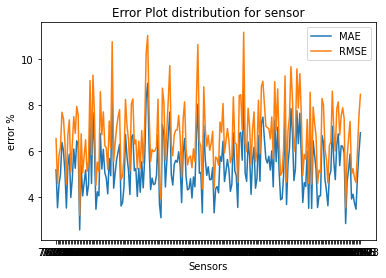

In [ ]:
ErrorData = pd.read_pickle("/content/drive/MyDrive/Traffic Prediction/Results/SVRErrorData.pkl")
print(ErrorData)

import matplotlib.pyplot as plt

plt.plot(sensor_list_la,ErrorData[0],label='MAE')
plt.plot(sensor_list_la,ErrorData[1],label='RMSE')
plt.legend()
plt.title('Error Plot distribution for sensor')
plt.xlabel('Sensors')
plt.ylabel('error %')
plt.show()